In [1]:
# Import necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers
import os

In [2]:
# Configure parameters
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32  # Reduced for directory-based loading
epochs = int(input("Enter epochs number: "))
image_size = 224  # Updated to match dataset
patch_size = 16  # Larger patches for 224x224 images
num_patches = (image_size // patch_size) ** 2
embed_dim = 128  # Increased for larger images
num_heads = 8
transformer_layers = 4  # Increased transformer layers
transfomer_units = [embed_dim * 2, embed_dim]
mlp_head_units = [2048, 1024]

Enter epochs number:  10


In [3]:
# Directory path for images
dataset_path = r'D:\Project\aug_data\data_aug'

In [4]:
# Load dataset from directory
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(image_size, image_size),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(image_size, image_size),
    batch_size=batch_size
)

Found 768 files belonging to 4 classes.
Using 615 files for training.
Found 768 files belonging to 4 classes.
Using 153 files for validation.


In [5]:
# Get number of classes dynamically
num_classes = len(train_ds.class_names)
print(f"Number of classes: {num_classes}")

Number of classes: 4


In [6]:
# Use data augmentation
data_augmentation = keras.Sequential(
    [
        layers.Rescaling(1./255),
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ],
    name='data_augmentation'
)

In [7]:
# Implement Multi-Layer Perceptron (MLP)
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# Create Vision Transformer Model
def vit_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Data augmentation
    augmented = data_augmentation(inputs)

    # Patch embedding
    patching = layers.Conv2D(embed_dim, kernel_size=patch_size, strides=patch_size, padding='valid', name='patching')(augmented)
    patches = layers.Reshape((num_patches, embed_dim), name='patches')(patching)

    # Positional embeddings
    position_embeddings = layers.Embedding(input_dim=num_patches, output_dim=embed_dim)(
        layers.Lambda(lambda x: tf.expand_dims(tf.range(num_patches), axis=0))(patches))

    # Add position embeddings to patches
    patches = layers.Add()([patches, position_embeddings])

    # Transformer blocks
    for _ in range(transformer_layers):
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim // num_heads)(patches, patches)
        x2 = layers.Add()([attention_output, patches])
        x2 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x2, hidden_units=transfomer_units, dropout_rate=0.1)
        patches = layers.Add()([x3, x2])
        patches = layers.LayerNormalization(epsilon=1e-6)(patches)

    # MLP head
    representation = layers.GlobalAveragePooling2D()(layers.Reshape((image_size // patch_size, image_size // patch_size, embed_dim))(patches))
    representation = layers.Dropout(0.5)(representation)
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)

    # Output layer
    outputs = layers.Dense(num_classes, activation='softmax')(features)

    model = keras.models.Model(inputs=inputs, outputs=outputs)
    return model

In [8]:
# Instantiate the model
vit_classifier = vit_model((image_size, image_size, 3), num_classes)

In [9]:
# Compile and Train Model
def run_experiment(model):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs
    )

    return history

In [10]:
# Train and Evaluate the Model
history = run_experiment(vit_classifier)

Epoch 1/10
20/20 [==============================] - 24s 212ms/step - loss: 1.6059 - accuracy: 0.2683 - val_loss: 1.5436 - val_accuracy: 0.2549
Epoch 2/10
20/20 [==============================] - 3s 145ms/step - loss: 1.6094 - accuracy: 0.2732 - val_loss: 1.4457 - val_accuracy: 0.2810
Epoch 3/10
20/20 [==============================] - 3s 142ms/step - loss: 1.5341 - accuracy: 0.2179 - val_loss: 1.3793 - val_accuracy: 0.2810
Epoch 4/10
20/20 [==============================] - 3s 142ms/step - loss: 1.4142 - accuracy: 0.3106 - val_loss: 1.2950 - val_accuracy: 0.3399
Epoch 5/10
20/20 [==============================] - 3s 143ms/step - loss: 1.3577 - accuracy: 0.3203 - val_loss: 1.2825 - val_accuracy: 0.3203
Epoch 6/10
20/20 [==============================] - 3s 143ms/step - loss: 1.1417 - accuracy: 0.4553 - val_loss: 1.1566 - val_accuracy: 0.3791
Epoch 7/10
20/20 [==============================] - 3s 142ms/step - loss: 0.9546 - accuracy: 0.5593 - val_loss: 0.7186 - val_accuracy: 0.6144
Epoch

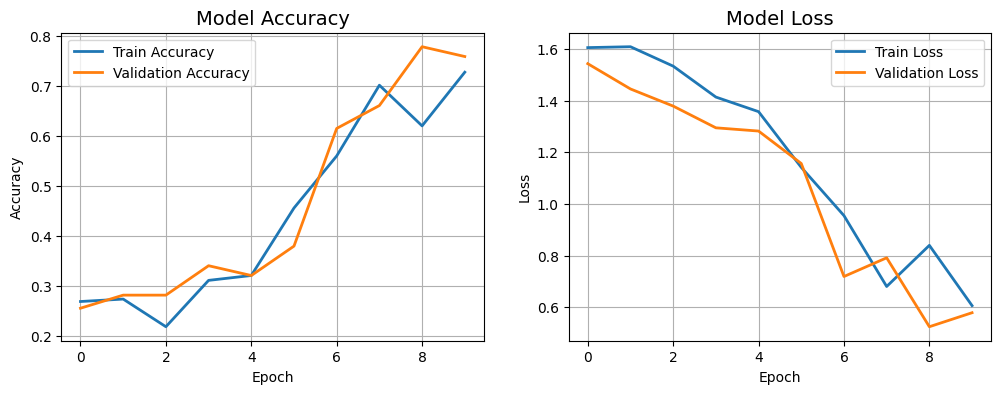

In [11]:
# Plot accuracy and loss curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.show()

Found 768 images belonging to 4 classes.


C:\Users\mohan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mohan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mohan\anaconda3\envs\gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       198
           1       0.00      0.00      0.00       186
           2       0.26      1.00      0.41       201
           3       0.00      0.00      0.00       183

    accuracy                           0.26       768
   macro avg       0.07      0.25      0.10       768
weighted avg       0.07      0.26      0.11       768



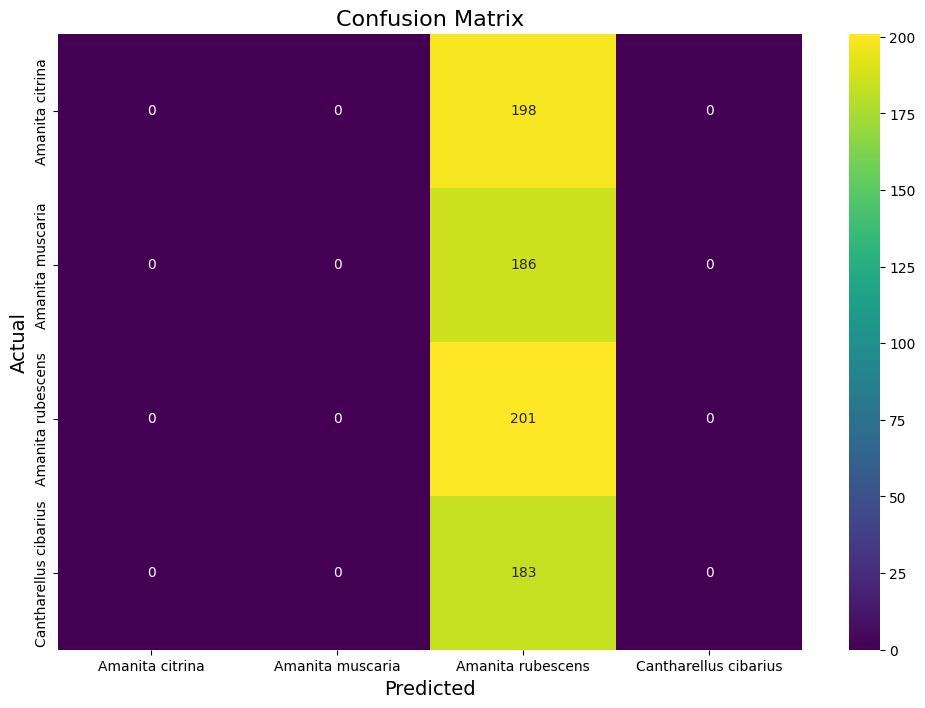

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create ImageDataGenerator for evaluation (use same preprocessing as training)
eval_datagen = ImageDataGenerator(rescale=1./255)  # Ensure images are normalized

# Define image size and batch size
image_size = (224, 224)
batch_size = 32

# Load evaluation dataset (ensure shuffle=False)
eval_generator = eval_datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Important for correct labels
)

# Get true labels
y_true = eval_generator.classes

# Predict using ViT model
y_pred = vit_classifier.predict(eval_generator)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Print classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred_classes))

# Generate confusion matrix
conf_mat = confusion_matrix(y_true, y_pred_classes)
class_labels = list(eval_generator.class_indices.keys())  # Get class names

# Plot confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="viridis", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()